In [23]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
import re
import matplotlib.pyplot as plt
import seaborn as sb

# Data exploration

In [57]:
df = pd.read_csv('data/colombia.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      303 non-null    object
 1   Price     303 non-null    object
 2   Open      303 non-null    object
 3   High      303 non-null    object
 4   Low       303 non-null    object
 5   Vol.      303 non-null    object
 6   Change %  303 non-null    object
dtypes: object(7)
memory usage: 16.7+ KB


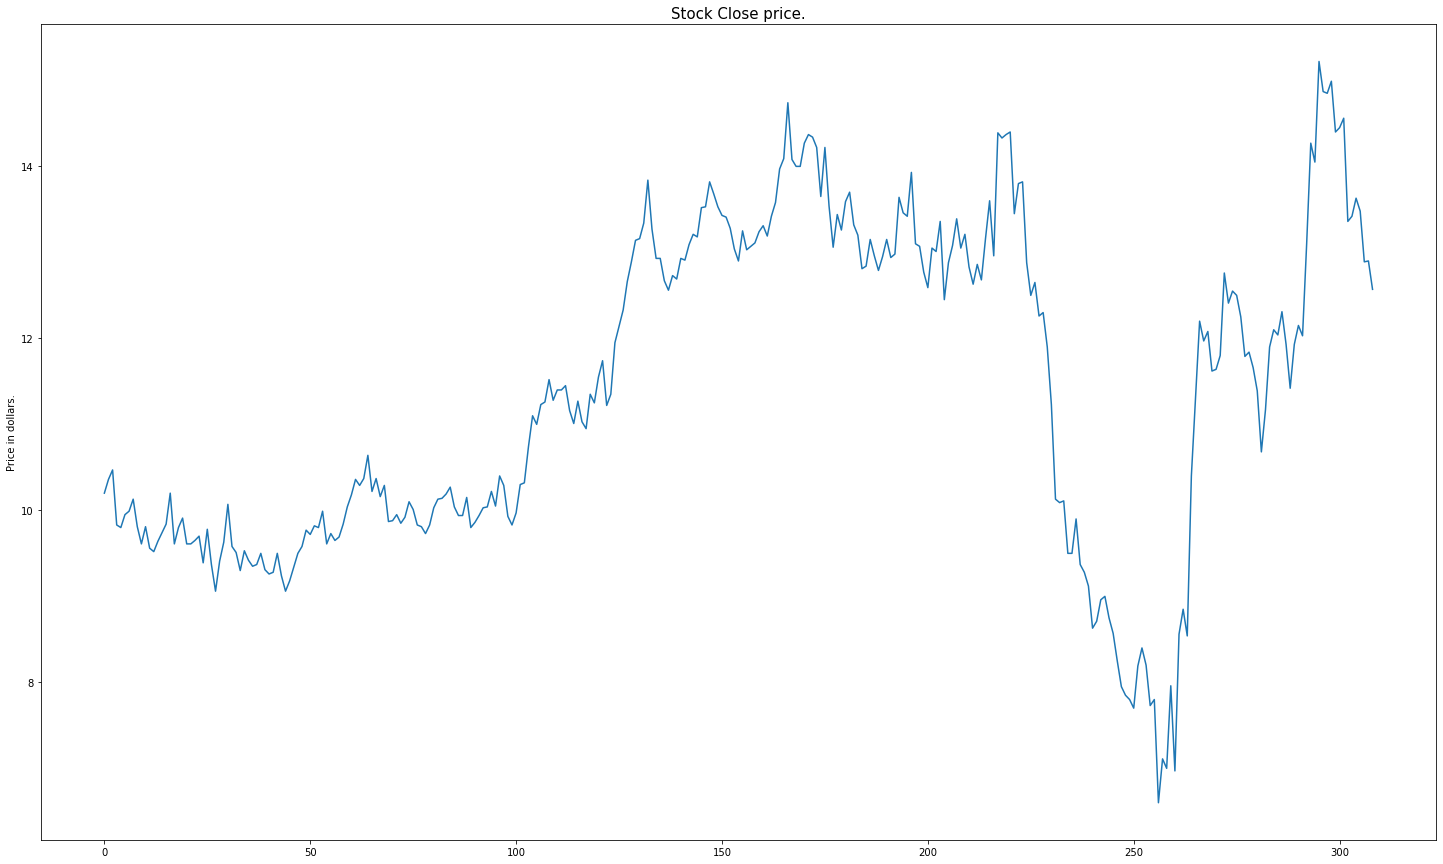

In [16]:
plt.figure(figsize=(25,15))
plt.plot(df['Price'])
plt.title('Stock Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

Checking for variance in data

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

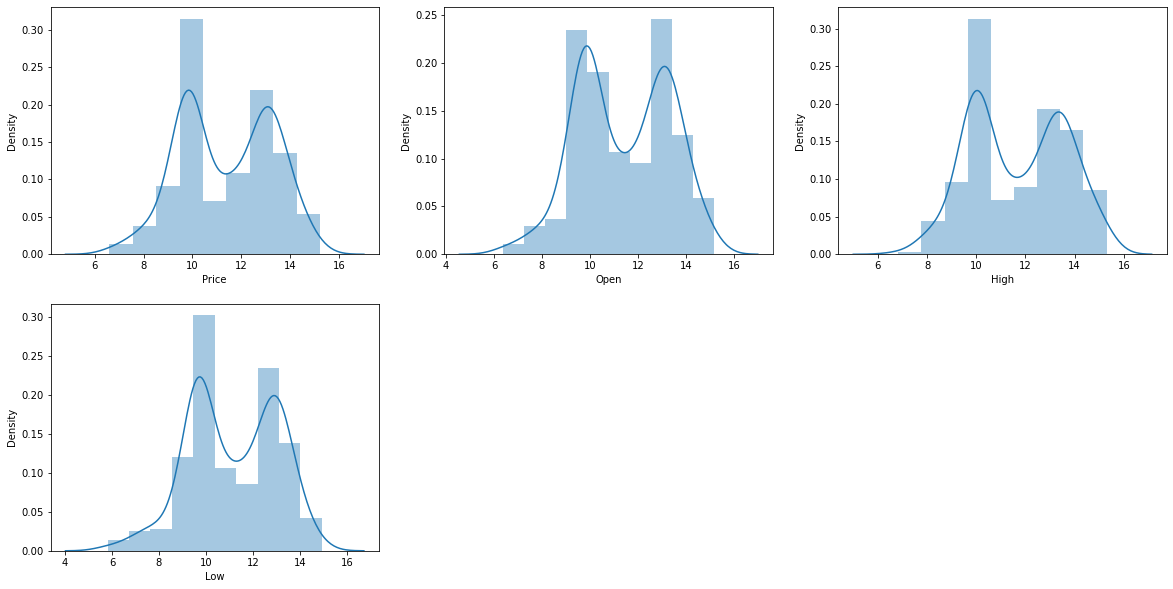

In [15]:
features = ['Price', 'Open', 'High', 'Low']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()

# Ploting Bollinger Bands

In [8]:
# function to calculate moving average, standard deviation, lower band, and upper bands
def bollinger_bands(data_frame,period):
    period = 20
    data_frame['MA'] = data_frame['Price'].rolling(window=period).mean()
    data_frame['std'] = data_frame['Price'].rolling(window=period).std()
    data_frame['Upper'] = data_frame['MA'] + (df['std'] * 2)
    data_frame['Lower'] = data_frame['MA'] - (df['std'] * 2)
    return data_frame['MA'],data_frame['std'],data_frame['Upper'],data_frame['Lower']

In [31]:
moving_avg,std,upper_band,lower_band = bollinger_bands(df,20)

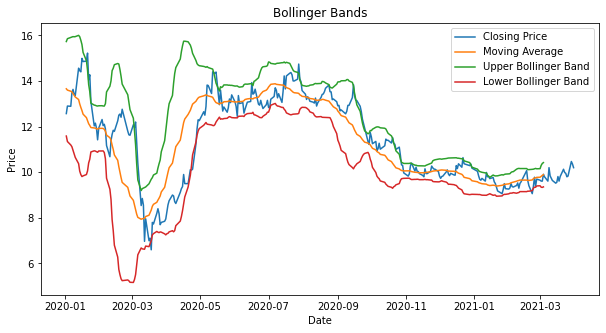

In [14]:
# ploting bollinger bands
df['Date'] = pd.to_datetime(df['Date'])
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df['Date'], df['Price'], label='Closing Price')
ax.plot(df['Date'], moving_avg, label='Moving Average')
ax.plot(df['Date'], upper_band, label='Upper Bollinger Band')
ax.plot(df['Date'], lower_band, label='Lower Bollinger Band')

ax.set_title('Bollinger Bands')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

plt.show()

In [17]:
# Creating signals based on a particular stock price
def bollinger_signal(close, lower, upper):
    """
    Generate Buy or Sell signal based on Bollinger Bands.
    
    Parameters:
    close (float): The closing price.
    lower (float): The lower Bollinger Band.
    upper (float): The upper Bollinger Band.
    
    Returns:
    signal (str): 'Buy' if the closing price is below the lower Bollinger Band, 
                  'Sell' if the closing price is above the upper Bollinger Band,
                  'Hold' otherwise.
    """
    if close < lower:
        signal = 'Buy'
    elif close > upper:
        signal = 'Sell'
    else:
        signal = 'Hold'
    
    return signal

In [33]:
df['Signal'] = df.apply(lambda x: bollinger_signal(x['Price'], x['Lower'], x['Upper']), axis=1)

In [42]:
# ploting the graph to show the BUY, SELL, and HOLD singals on the original time-series data
def plot_bollinger_bands(df,moving_avg,upper_band,lower_band,stock_name):
    df['Date'] = pd.to_datetime(df['Date'])
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(df['Date'], df['Price'], label='Closing Price')
    ax.plot(df['Date'], moving_avg, label='Moving Average')
    ax.plot(df['Date'], upper_band, label='Upper Bollinger Band')
    ax.plot(df['Date'], lower_band, label='Lower Bollinger Band')

    for i in range(len(df)):
        if df['Signal'][i] == 'Buy':
            plt.axvline(df['Date'][i], color='green', alpha=0.5)
        elif df['Signal'][i] == 'Sell':
            plt.axvline(df['Date'][i], color='red', alpha=0.5)

    ax.set_title('Bollinger Bands - '+ stock_name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    plt.show()

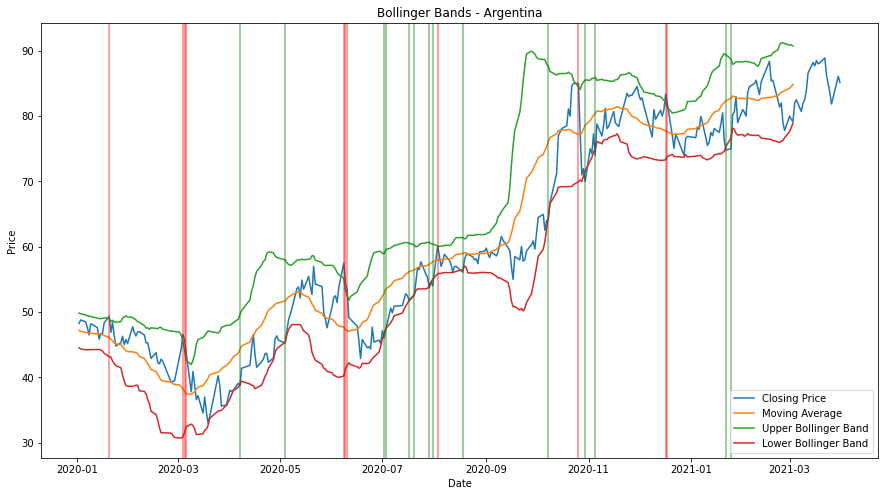

In [43]:
plot_bollinger_bands(df,moving_avg,upper_band,lower_band,"Argentina")

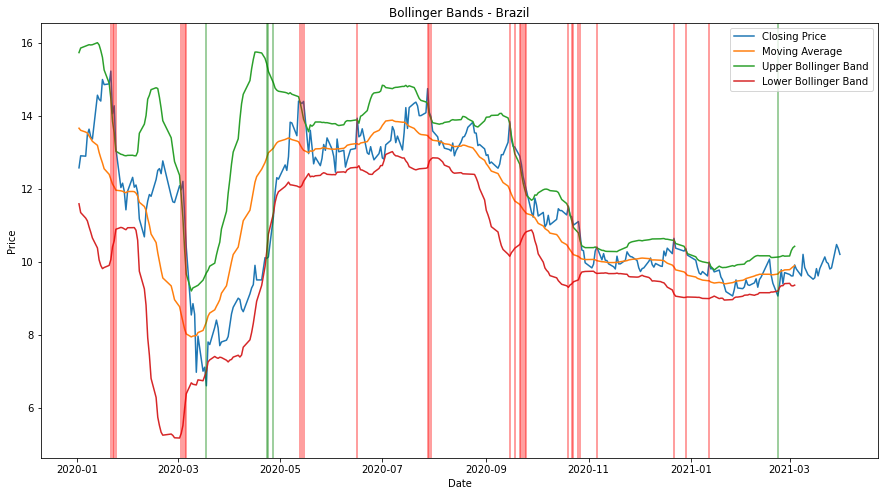

In [46]:
df = pd.read_csv('data/brazil.csv')
moving_avg,std,upper_band,lower_band = bollinger_bands(df,20)
df['Signal'] = df.apply(lambda x: bollinger_signal(x['Price'], x['Lower'], x['Upper']), axis=1)
plot_bollinger_bands(df,moving_avg,upper_band,lower_band,"Brazil")

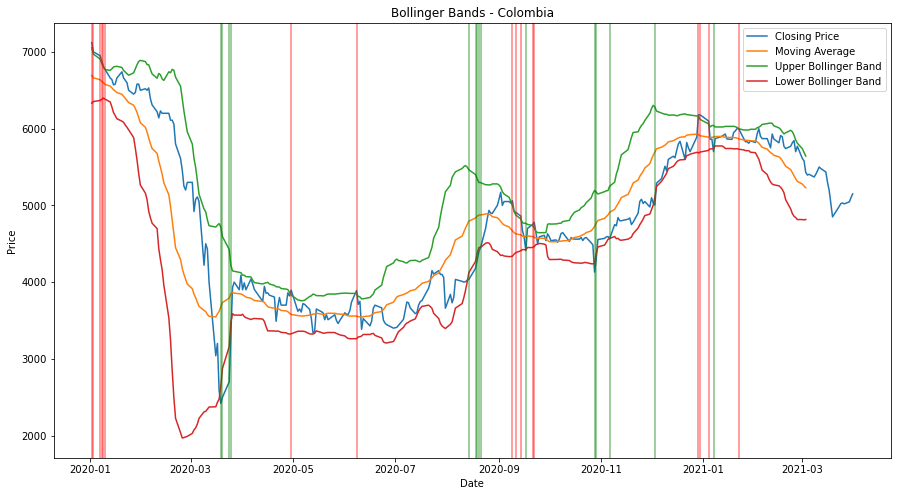

In [61]:
df = pd.read_csv('data/colombia.csv')
df['Price'] = df['Price'].str.replace(',', '')
df['Price'] = df['Price'].astype(float)
moving_avg,std,upper_band,lower_band = bollinger_bands(df,20)
df['Signal'] = df.apply(lambda x: bollinger_signal(x['Price'], x['Lower'], x['Upper']), axis=1)
plot_bollinger_bands(df,moving_avg,upper_band,lower_band,"Colombia")

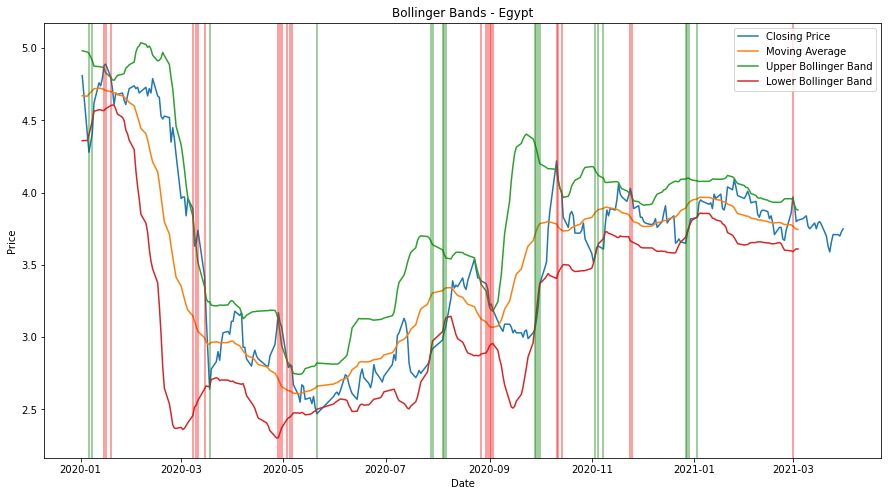

In [67]:
df = pd.read_csv('data/egypt.csv')
# df['Price'] = df['Price'].str.replace(',', '')
# df['Price'] = df['Price'].astype(float)
moving_avg,std,upper_band,lower_band = bollinger_bands(df,20)
df['Signal'] = df.apply(lambda x: bollinger_signal(x['Price'], x['Lower'], x['Upper']), axis=1)
plot_bollinger_bands(df,moving_avg,upper_band,lower_band,"Egypt")

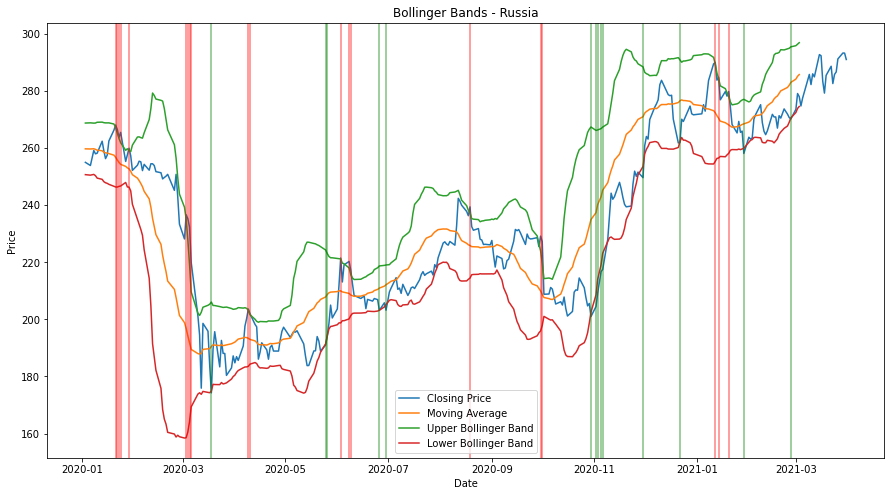

In [69]:
df = pd.read_csv('data/russia.csv')
# df['Price'] = df['Price'].str.replace(',', '')
# df['Price'] = df['Price'].astype(float)
moving_avg,std,upper_band,lower_band = bollinger_bands(df,20)
df['Signal'] = df.apply(lambda x: bollinger_signal(x['Price'], x['Lower'], x['Upper']), axis=1)
plot_bollinger_bands(df,moving_avg,upper_band,lower_band,"Russia")

# Predicting stock price using ARIMA model

For the data to be processed, we need to do some cleaning and transformations.

- Convert date format
- Change Vol. from percentage to real numbers
- Change values from million, and K to real numbers
- Changing data type from Object to float for some of the columns

In [79]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%b %d, %Y')
# loading data for Argentina
argentina_df = pd.read_csv('data/argentina.csv',sep=',', parse_dates=['Date'], date_parser=dateparse).fillna(0)
argentina_df['Vol.'] = (argentina_df['Vol.'].replace(r'[KM]+$', '', regex=True)
                           .astype(float) * argentina_df['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False)
                           .fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))

# loading data for Brazil
brazil_df = pd.read_csv('data/brazil.csv',sep=',', parse_dates=['Date'], date_parser=dateparse).fillna(0)
brazil_df['Vol.'] = (brazil_df['Vol.'].replace(r'[KM]+$', '', regex=True)
                           .astype(float) * brazil_df['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False)
                           .fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))

# loading data for Colombia
colombia_df = pd.read_csv('data/colombia.csv',sep=',', parse_dates=['Date'], date_parser=dateparse).fillna(0)
colombia_df['Vol.'] = (colombia_df['Vol.'].replace(r'[KM]+$', '', regex=True)
                           .astype(float) * colombia_df['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False)
                           .fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
colombia_df['Price'] = colombia_df['Price'].str.replace(',', '')
colombia_df['Price'] = colombia_df['Price'].astype(float)
colombia_df['Open'] = colombia_df['Open'].str.replace(',', '')
colombia_df['Open'] = colombia_df['Open'].astype(float)
colombia_df['High'] = colombia_df['High'].str.replace(',', '')
colombia_df['High'] = colombia_df['High'].astype(float)
colombia_df['Low'] = colombia_df['Low'].str.replace(',', '')
colombia_df['Low'] = colombia_df['Low'].astype(float)

# loading data for Egypt
egypt_df = pd.read_csv('data/egypt.csv',sep=',', parse_dates=['Date'], date_parser=dateparse).fillna(0)
egypt_df['Vol.'] = (egypt_df['Vol.'].replace(r'[KM]+$', '', regex=True)
                           .astype(float) * egypt_df['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False)
                           .fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/3666261852.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%b %d, %Y')
/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/3666261852.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%b %d, %Y')
/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/3666261852.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%b %d, %Y')
/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/3666261852.py:1: FutureWarning: The pandas.date

In [82]:
# Function for splitting data
def split_data(start_date,end_date,df,):
    test = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    train = df[~df.index.isin(test.index)]
    X_train = train[['Date','Price']]
    X_train['Date'] = pd.to_datetime(X_train['Date'])
    X_train.set_index('Date', inplace=True)
    y_test = test[['Date','Price']]
    y_test['Date'] = pd.to_datetime(y_test['Date'])
    y_test.set_index('Date', inplace=True)
    return X_train, y_test

In [95]:
#Function for running the ARIMA model
def arimaModel(X_train,y_test,period,stock_name):
    model = auto_arima(X_train, start_p=0, start_q=0, max_p=3, max_q=3, m=1,
                   start_P=0, seasonal=False, d=None, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True)

    forecast, conf_int = model.predict(n_periods=period, index=y_test.index, return_conf_int=True)
    model.plot_diagnostics(figsize=(15,8))
    plt.show()
    mse = mean_squared_error(y_test[:period], forecast)
    mape = mean_absolute_percentage_error(y_test[:30], forecast)
    print('MSE for '+stock_name+' for ',period,'days is', mse)
    print('MAPE for '+stock_name+' for',period,'days is', mape)

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/794647489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Date'] = pd.to_datetime(X_train['Date'])
/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/794647489.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Date'] = pd.to_datetime(y_test['Date'])
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1030.896, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1031.735, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1031.803, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1029.693, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1032.387, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.089 seconds


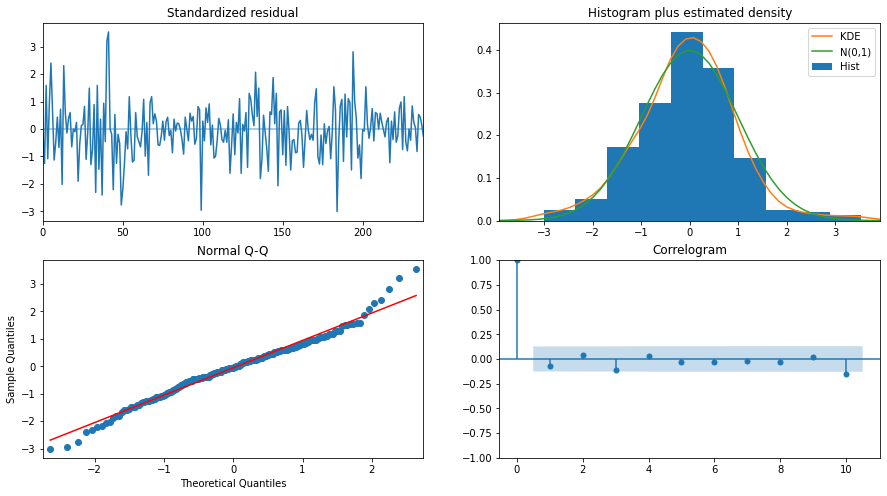

MSE for Argentina for  30 days is 1284.8709166666665
MAPE for Argentina for 30 days is 0.42438054491362126


In [96]:
X_train, y_test = split_data('2021-01-01','2021-03-31',argentina_df)
arimaModel(X_train,y_test,30,"Argentina")

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/794647489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Date'] = pd.to_datetime(X_train['Date'])
/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/794647489.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Date'] = pd.to_datetime(y_test['Date'])


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1943.520, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=277.994, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=280.975, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=273.875, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1340.111, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=274.368, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=268.474, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1136.351, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=269.622, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=261.899, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=511.792, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=268.521, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=263.275, T

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


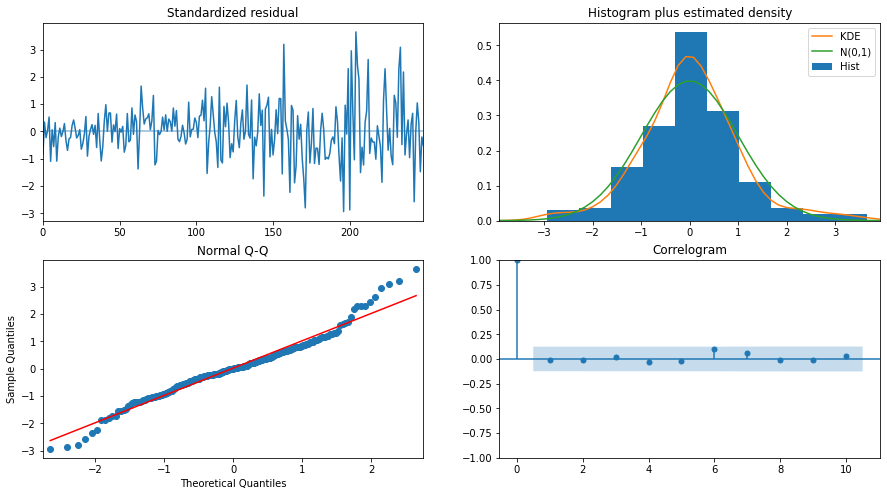

MSE for Brazil for  30 days is 5.402871864082215
MAPE for Brazil for 30 days is 0.23776697538849093


In [97]:
X_train, y_test = split_data('2021-01-01','2021-03-31',brazil_df)
arimaModel(X_train,y_test,30,"Brazil")

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/794647489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Date'] = pd.to_datetime(X_train['Date'])
/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/794647489.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Date'] = pd.to_datetime(y_test['Date'])


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3269.143, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3196.427, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3267.144, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=3179.637, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=3156.003, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=3154.025, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3177.641, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=3128.350, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3126.359, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3126.419, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3125.111, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3127.7

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


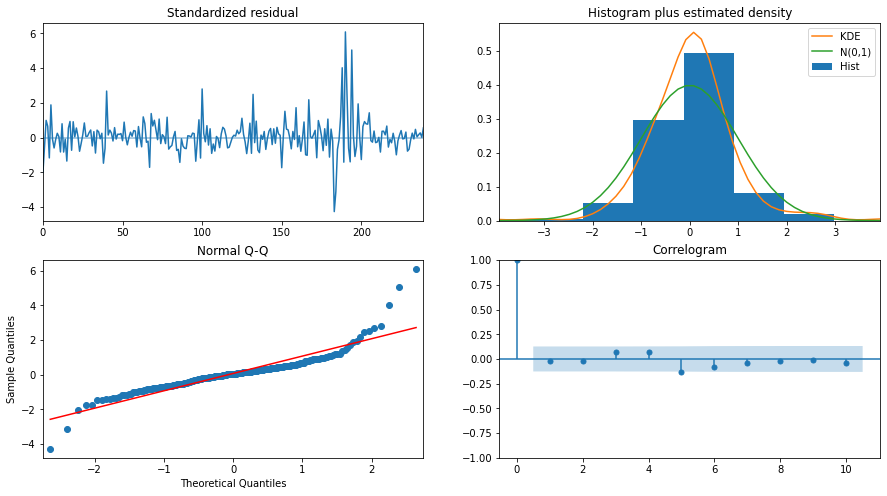

MSE for Colombia for  30 days is 5303983.319495867
MAPE for Colombia for 30 days is 0.4270776784452782


In [98]:
X_train, y_test = split_data('2021-01-01','2021-03-31',colombia_df)
arimaModel(X_train,y_test,30,"Colombia")

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/794647489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Date'] = pd.to_datetime(X_train['Date'])
/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_31904/794647489.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Date'] = pd.to_datetime(y_test['Date'])


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-460.434, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-473.345, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-472.224, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-461.963, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-471.346, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-471.346, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-469.353, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-474.986, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-472.988, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-472.987, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-473.835, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-470.995, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.262 seconds


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


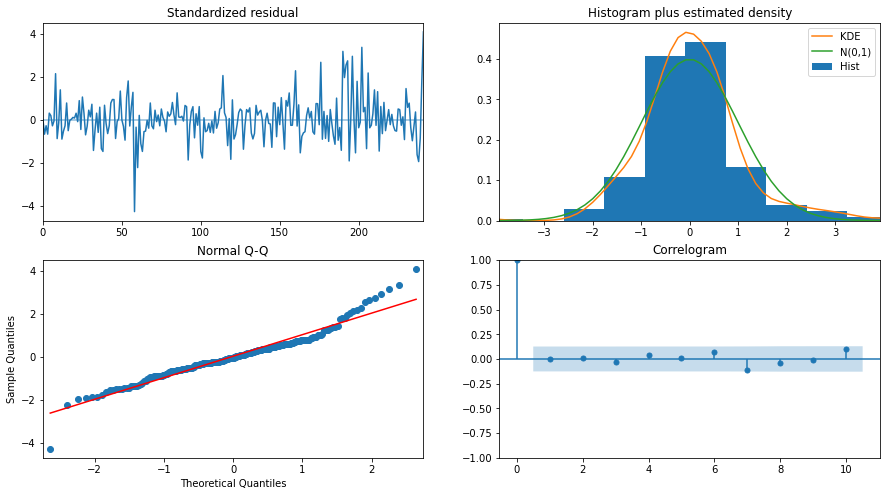

MSE for Egypt for  30 days is 1.4131888764754554
MAPE for Egypt for 30 days is 0.31612652534820285


In [99]:
X_train, y_test = split_data('2021-01-01','2021-03-31',egypt_df)
arimaModel(X_train,y_test,30,"Egypt")